# Audio Classification 

This is Audio Recogination Problem. The Challange is to build a Machine Learning code to count the number of Capuchinbird calls within a gien clip.

The Data is collected from the Kaggle Dataset ,https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing.

### Understanding the Data

We have Three folders(Three types of Data).
1. Forest Clips : Foreclip we need to parse and count the number of calls
2. Parsed_Capuchinbird_clips : Calls related to specific capuchin bird.
3. Parsed Not Capuchin Bird : Set of files which are not Capuchin Bird Calls.

## Installing Dependencies

In [1]:
# !pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

## Loading Dependencies

In [174]:
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import gc
gc.collect()

43234

## Config

In [54]:
class CFG:
    CAP_DATA = os.path.join("..","data",'Parsed_Capuchinbird_Clips')
    NON_CAP_DATA = os.path.join("..",'data','Parsed_Not_Capuchinbird_Clips')
    FOREST_DATA = os.path.join("..","data",'Forest Recordings')
    TARGET_SR = 16000

    BATCH_SIZE = 16
    TRAIN_SIZE = 0.7
config = CFG()
gc.collect()

36785

## Loading data

In [4]:
CAP_file = os.path.join(CFG.CAP_DATA,"XC114131-0.wav")
NOT_cap_file = os.path.join(CFG.NON_CAP_DATA,"afternoon-birds-song-in-forest-15.wav")

In [5]:
CAP_file,NOT_cap_file

('../data/Parsed_Capuchinbird_Clips/XC114131-0.wav',
 '../data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-15.wav')

### Data Loading Function

The dunctions loads the file, then decodes the wav , remove the trailing axis.

It then converts the source sample rate to 16khz.

In [6]:
def  load_wav_file(filename,sr = CFG.TARGET_SR):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate,dtype=tf.int64)

    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=sr)
    return wav

In [7]:
cap_file = load_wav_file(CAP_file)
non_cap_file = load_wav_file(NOT_cap_file)
gc.collect()

2024-04-09 18:41:44.241315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 18:41:44.269015: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-04-09 18:41:44.344905: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 FMA
2024-04-09 18:41:44.346991: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


0

## Plotting Audio Files

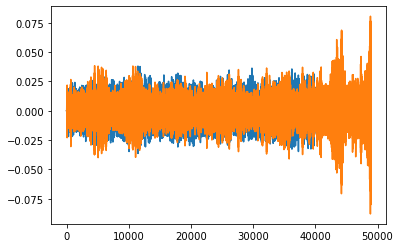

In [8]:
plt.plot(cap_file)
plt.plot(non_cap_file)
plt.show()

## Creating Tensorflow Datasets

In [9]:
cap_dataset = tf.data.Dataset.list_files(config.CAP_DATA+'/*.wav')
non_cap_dataset = tf.data.Dataset.list_files(config.NON_CAP_DATA+'/*.wav')

In [10]:
# Combining the labels.
cap_dataset_1 = tf.data.Dataset.zip((cap_dataset,tf.data.Dataset.from_tensor_slices(tf.ones(len(cap_dataset)))))
non_cap_dataset_1 = tf.data.Dataset.zip((non_cap_dataset,tf.data.Dataset.from_tensor_slices(tf.zeros(len(non_cap_dataset)))))
dataset = cap_dataset_1.concatenate(non_cap_dataset_1)

gc.collect()

3089

In [11]:
dataset = dataset.shuffle(10012,seed = 42)

### Determine the average length of audio calls.

In [12]:
# Calculating the Wavelength

lengths = []
for file in os.listdir(config.CAP_DATA):
    tensor_wave = load_wav_file(os.path.join(config.CAP_DATA,file))
    lengths.append(len(tensor_wave))

In [13]:
cap_min_length = min(lengths)
cap_max_length = max(lengths)
cap_avg_length = sum(lengths)/len(lengths)

In [14]:
print(f"maximum length is {cap_max_length} while minimum is {cap_min_length} with average is {cap_avg_length}.\nSo the longest audio is of {cap_max_length/config.TARGET_SR}. \nSmallest song of length {cap_min_length/config.TARGET_SR}")

maximum length is 80000 while minimum is 32000 with average is 54156.66359447005.
So the longest audio is of 5.0. 
Smallest song of length 2.0


## Building a Preprocessing and converting it into spectogram.

In [15]:
def preprocess(file_path, label):
    wav = load_wav_file(file_path)
    wav = wav[:48000]
    zero_paddings = tf.zeros([48000]- tf.shape(wav),dtype=tf.float32)
    wav = tf.concat([zero_paddings,wav],0)

    # Spectogram
   
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis =2)
    return spectogram,label

gc.collect()

0

In [16]:
samp_file_path , sample_label = cap_dataset_1.as_numpy_iterator().next()
samp_spectogram,_ = preprocess(samp_file_path,sample_label)
gc.collect()

0

### Plotting sample Spectogram

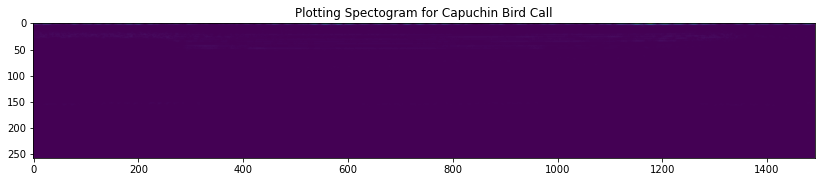

In [17]:
plt.figure(figsize=(14,5))
plt.title("Plotting Spectogram for Capuchin Bird Call")
plt.imshow(tf.transpose(samp_spectogram)[0])
plt.show()

In [18]:
samp_file_path , sample_label = non_cap_dataset_1.as_numpy_iterator().next()
samp_spectogram,_ = preprocess(samp_file_path,sample_label)

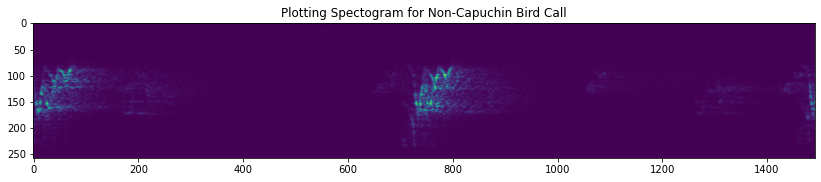

6206

In [19]:
plt.figure(figsize=(14,5))
plt.title("Plotting Spectogram for Non-Capuchin Bird Call")
plt.imshow(tf.transpose(samp_spectogram)[0])
plt.show()
gc.collect()

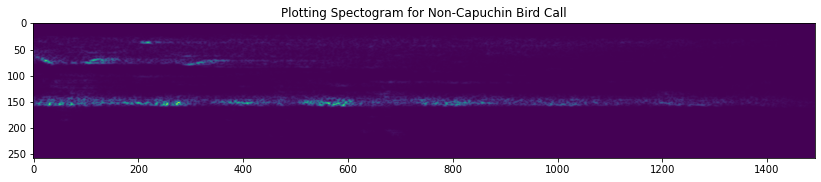

In [20]:
samp_file_path , sample_label = non_cap_dataset_1.as_numpy_iterator().next()
samp_spectogram,_ = preprocess(samp_file_path,sample_label)

plt.figure(figsize=(14,5))
plt.title("Plotting Spectogram for Non-Capuchin Bird Call")
plt.imshow(tf.transpose(samp_spectogram)[0])
plt.show()

There is pattern between the Capuchin Bird call and Other Bird call, there is a pattern.

### Splitting Data in Train and Test Partations

In [21]:
# Preprocessing the Dataset.
dataset =  dataset.map(preprocess)
# Cache the Dataset
dataset  = dataset.cache()
# Shuffling and Batching the dataset
dataset= dataset.shuffle(10000).batch(config.BATCH_SIZE)
dataset = dataset.prefetch(8)

In [22]:
train_ds = dataset.take(int(len(dataset)*config.TRAIN_SIZE))
test_ds = dataset.skip(int(len(dataset)*config.TRAIN_SIZE))
gc.collect()

3104

#### Testing on Batch

In [23]:
samples, labels = train_ds.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

## Building Model

In [24]:
def get_model():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape = (1491,257,1)))
    model.add(Conv2D(16,(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer = 'adam',loss = tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
    return model

In [25]:
model = get_model()
gc.collect()

2024-04-09 18:41:58.952422: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1540960256 exceeds 10% of free system memory.
2024-04-09 18:41:59.350583: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1540960256 exceeds 10% of free system memory.
2024-04-09 18:41:59.546371: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1540960256 exceeds 10% of free system memory.


118

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 64)                385240128 
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385242673 (1.44 GB)
Trainable params: 385242673 (1.44 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training Model

In [27]:
hist  = model.fit(train_ds, epochs=3, validation_data=test_ds)

Epoch 1/3


2024-04-09 18:42:00.255565: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1540960256 exceeds 10% of free system memory.
2024-04-09 18:42:00.415858: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1540960256 exceeds 10% of free system memory.


35/35 [==============================] - 172s 5s/step - loss: 1.0760 - recall: 0.8750 - precision: 0.8210 - val_loss: 0.0581 - val_recall: 0.9855 - val_precision: 0.9855
Epoch 2/3
35/35 [==============================] - 173s 5s/step - loss: 0.1091 - recall: 0.9742 - precision: 0.9934 - val_loss: 0.0140 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/3
35/35 [==============================] - 192s 6s/step - loss: 0.0338 - recall: 0.9808 - precision: 0.9871 - val_loss: 0.0204 - val_recall: 1.0000 - val_precision: 0.9875


### Plotting Metrcis

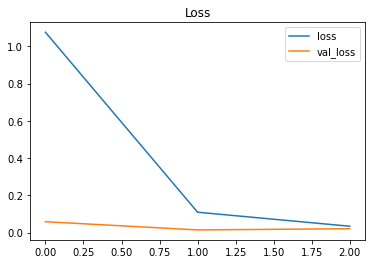

In [32]:
plt.title('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

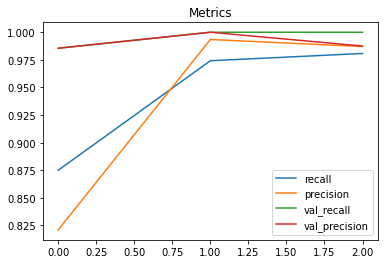

In [34]:
plt.title('Metrics')
plt.plot(hist.history['recall'])
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_recall'])
plt.plot(hist.history['val_precision'])

plt.legend(['recall','precision','val_recall','val_precision'])
plt.show()

# Making Prediction

In [35]:
X_test, y_test = test_ds.as_numpy_iterator().next()

In [36]:
X_test.shape, y_test.shape

((16, 1491, 257, 1), (16,))

In [37]:
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 583ms/step


In [41]:
y_pred = [1 if pred >0.5 else 0 for pred in y_pred]

#### Checking Accuracy

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Accuracy = ",accuracy_score(y_test, y_pred),"\nConfusion Matrix \n",confusion_matrix(y_test,y_pred))

Accuracy =  0.9375 
Confusion Matrix 
 [[9 1]
 [0 6]]


### Saving Model Weights

In [196]:
model.save('./model')

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


## Building Prediction for Forest Recordings

In [118]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [139]:
samp = os.listdir(config.FOREST_DATA)[0]

wav = load_mp3_16k_mono(os.path.join(config.FOREST_DATA,samp))
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
gc.collect()

5778

#### Building Function to convert clips in windows spectograms

In [140]:

def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [141]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)
gc.collect()

560

In [149]:
ypred = model.predict(audio_slices)

1/1 [==============================] - 2s 2s/step


In [150]:
ypred = [1 if prediction > 0.99 else 0 for prediction in ypred]

In [151]:
# Reducing the consective calls and single calls

In [152]:
from itertools import groupby

In [154]:
ypred = [key for key, group in groupby(ypred)]
calls = tf.math.reduce_sum(ypred).numpy()

# Predicting on foreset Recordings folder

In [156]:
from tqdm import tqdm

In [164]:
result = {}
for file in tqdm(os.listdir(config.FOREST_DATA)):
    FILE_PATH = os.path.join(config.FOREST_DATA,file)
    wav = load_mp3_16k_mono(FILE_PATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(
        wav,
        wav,
        sequence_length=48000,
        sequence_stride=48000,
    batch_size=1
    ).map(preprocess_mp3).batch(64)
    y_hat = model.predict(audio_slices,verbose=0)
    result[file]=y_hat

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.14s/it]


In [168]:
# Converting to classes
class_preds = {}
for file,logits in result.items():
     class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]


In [187]:
# Counting the total number of classes from the file
final_calls={}
for file,classes in class_preds.items():
    classes = [key for key, group in groupby(classes)]
    final_calls[file] = [tf.math.reduce_sum(classes).numpy()]

In [188]:
final_calls['recording_98.mp3']

[14]

### Saving

In [190]:
pd.DataFrame(final_calls,)

,recording_44.mp3,recording_84.mp3,recording_56.mp3,recording_60.mp3,recording_42.mp3,recording_22.mp3,recording_69.mp3,recording_95.mp3,recording_77.mp3,recording_71.mp3,...,recording_98.mp3,recording_90.mp3,recording_96.mp3,recording_30.mp3,recording_83.mp3,recording_48.mp3,recording_65.mp3,recording_47.mp3,recording_99.mp3,recording_24.mp3
0,1,1,1,5,0,2,1,5,2,8,...,14,0,1,3,0,4,5,1,5,0
